# Mapping Coastal Water Quality Transect Data with Cartopy
Cartopy Source: https://scitools.org.uk/cartopy/docs/latest/_modules/cartopy/io/img_tiles.html. 

Here is some code that plots **geolocated** water quality sensor data on a cartopy basemap using Mapbox examples.

## Open in Colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SUPScientist/Smart-Coasts/blob/main/assets/analysis/exo2_data_mapping_cartopy.ipynb)

## Technical details
- I'm using cartopy 0.20.3: https://scitools.org.uk/cartopy/docs/latest/citation.html
- Here's cartopy's example for using the Stamen tiles: https://github.com/SciTools/cartopy/blob/main/examples/web_services/image_tiles.py. 
- Lots of other options for basemaps. See Map subheading for more.

In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr

# Important!!! 
If running this script on your desktop installation of Jupyter notebook, you should run `conda install cartopy`. But if running from the cloud (Google Colab), uncomment the three pip install magics below to get it configured properly (remove the "# " before the "!"). 

## Install/uninstall proper mapping packages
We need cartopy which relies on shapely. But the wrong version of shapely will crash the program. So uninstall the wrong shapely and reinstall the right one. Explained here: https://stackoverflow.com/questions/60111684/geometry-must-be-a-point-or-linestring-error-using-cartopy. 

In [2]:
# !pip install cartopy
# !pip uninstall -y shapely 
# !pip install shapely --no-binary shapely

In [3]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Time zone conversions
Occasionally helpful to be able to convert from one time zone to another

In [4]:
import pytz
pacific = pytz.timezone('US/Eastern')

## Read in data using pandas
Pandas function "read_csv" pulls in a .csv file and can interpret the comma-separated values as corresponding to unique columns. 

In [5]:
data_url = 'https://raw.githubusercontent.com/SUPScientist/Smart-Coasts/main/assets/data/KorEXO%20Measurement%20File%20Export%20-%20111822%20163238.csv'

In [6]:
df_full = pd.read_csv(data_url, parse_dates=[[0,1]], header = 8) # Carolina Runner/Banks Channel

df_full.head()

,Date (MM/DD/YYYY)_Time (HH:mm:ss),Time (Fract. Sec),Site Name,Chlorophyll RFU,Cond µS/cm,Depth m,nLF Cond µS/cm,ODO % sat,ODO % local,ODO mg/L,...,pH,pH mV,Temp ºC,Vertical Position m,GPS Latitude º,GPS Longitude º,Altitude m,Battery V,Cable Pwr V,Barometer mmHg
0,2022-11-17 11:08:06,0,<None>,0.31,43689.8,0.228,54819.1,86.2,85.5,6.98,...,7.78,-54.1,15.004,0.194,34.15601,-77.85657,0.0,5.9,12.1,767.0
1,2022-11-17 11:08:07,0,<None>,0.33,43718.3,0.227,54840.6,86.2,85.5,6.98,...,7.78,-54.1,15.015,0.189,34.15601,-77.85657,-3.1,5.9,12.1,767.0
2,2022-11-17 11:08:08,0,<None>,0.33,43723.5,0.225,54843.2,86.2,85.5,6.98,...,7.78,-54.2,15.018,0.188,34.15604,-77.85658,-3.0,5.9,12.1,767.0
3,2022-11-17 11:08:09,0,<None>,0.34,43740.8,0.224,54856.7,86.2,85.4,6.98,...,7.78,-54.2,15.024,0.185,34.15602,-77.85661,4.4,5.9,12.1,767.1
4,2022-11-17 11:08:10,0,<None>,0.34,43756.0,0.222,54862.6,86.2,85.5,6.98,...,7.78,-54.2,15.035,0.191,34.15603,-77.85659,5.5,5.9,12.1,767.0


## Column headers
Pull from these columns when choosing what to plot below

In [7]:
df_full.columns

Index(['Date (MM/DD/YYYY)_Time (HH:mm:ss)', 'Time (Fract. Sec)', 'Site Name',
       'Chlorophyll RFU', 'Cond µS/cm', 'Depth m', 'nLF Cond µS/cm',
       'ODO % sat', 'ODO % local', 'ODO mg/L', 'Pressure psi a', 'Sal psu',
       'SpCond µS/cm', 'TAL PE RFU', 'TDS mg/L', 'Turbidity FNU', 'TSS mg/L',
       'pH', 'pH mV', 'Temp ºC', 'Vertical Position m', 'GPS Latitude º',
       'GPS Longitude º', 'Altitude m', 'Battery V', 'Cable Pwr V',
       'Barometer mmHg'],
      dtype='object')

## Truncation
Often necessary to remove chunks of data due to known issues (e.g., sensor out of water during this time period). Check lab notebook for rationale and equate `df_trunc` to `df_full` if no truncation necessary

In [8]:
df_trunc = df_full#[19:335]
df_trunc.head()

,Date (MM/DD/YYYY)_Time (HH:mm:ss),Time (Fract. Sec),Site Name,Chlorophyll RFU,Cond µS/cm,Depth m,nLF Cond µS/cm,ODO % sat,ODO % local,ODO mg/L,...,pH,pH mV,Temp ºC,Vertical Position m,GPS Latitude º,GPS Longitude º,Altitude m,Battery V,Cable Pwr V,Barometer mmHg
0,2022-11-17 11:08:06,0,<None>,0.31,43689.8,0.228,54819.1,86.2,85.5,6.98,...,7.78,-54.1,15.004,0.194,34.15601,-77.85657,0.0,5.9,12.1,767.0
1,2022-11-17 11:08:07,0,<None>,0.33,43718.3,0.227,54840.6,86.2,85.5,6.98,...,7.78,-54.1,15.015,0.189,34.15601,-77.85657,-3.1,5.9,12.1,767.0
2,2022-11-17 11:08:08,0,<None>,0.33,43723.5,0.225,54843.2,86.2,85.5,6.98,...,7.78,-54.2,15.018,0.188,34.15604,-77.85658,-3.0,5.9,12.1,767.0
3,2022-11-17 11:08:09,0,<None>,0.34,43740.8,0.224,54856.7,86.2,85.4,6.98,...,7.78,-54.2,15.024,0.185,34.15602,-77.85661,4.4,5.9,12.1,767.1
4,2022-11-17 11:08:10,0,<None>,0.34,43756.0,0.222,54862.6,86.2,85.5,6.98,...,7.78,-54.2,15.035,0.191,34.15603,-77.85659,5.5,5.9,12.1,767.0


# To change the plots content...
assign a value to `var_name` in the code chunk below using the column headers (i.e., the results of the command `df_full.columns`) shown above. Put it inside the single quotes. Choose an environmental variable, like conductivity, dissolved oxygen, pH, turbidity, temperature, or salinity. Not a spatial variable like latitude or time, or site name, or battery, or power. 

## Get parameters of interest and set limits

In [29]:
# Note that parameters must be an EXACT copy and paste of their names from columns above
lat = df_trunc["GPS Latitude º"]
lon = df_trunc["GPS Longitude º"]
var_name = 'Temp ºC' # selected from columns above
plot_var = df_trunc[var_name]
plot_var_min  = min(plot_var) # set manually if desired
plot_var_max  = max(plot_var)
fontsize = 16

## Time-series plot of parameter of interest

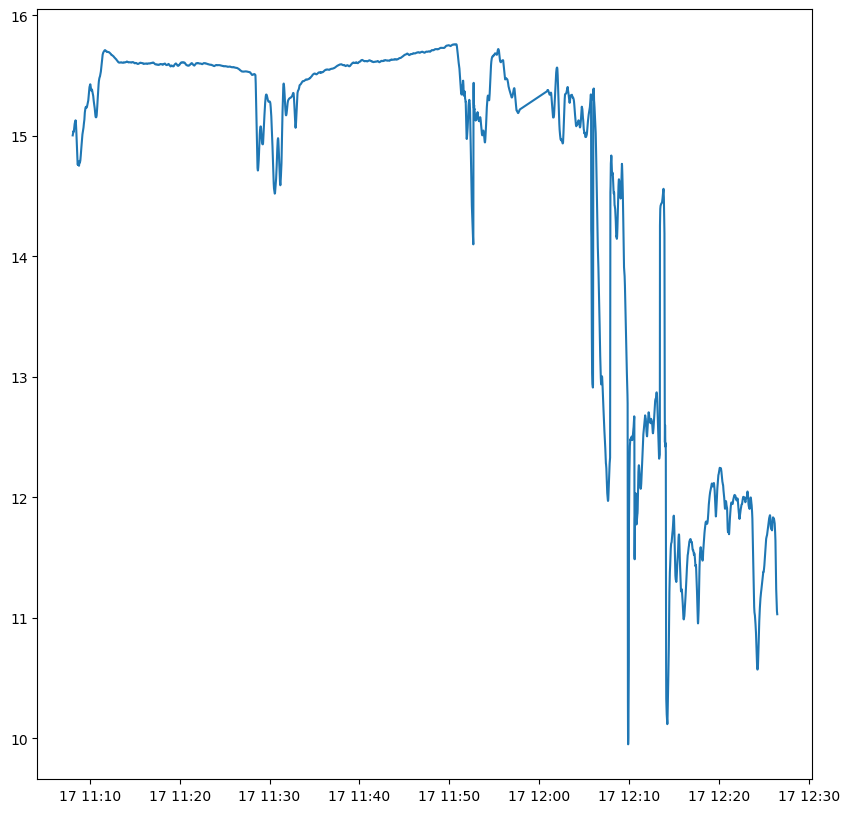

In [30]:
fig, axs = plt.subplots(figsize = (10, 10))
axs.plot(df_trunc['Date (MM/DD/YYYY)_Time (HH:mm:ss)'], df_trunc[var_name])

## Map of variable of interest
- Image tile options via Cartopy are currently buried in the API under cartopy.io.img_tiles described here: https://scitools.org.uk/cartopy/docs/latest/_modules/cartopy/io/img_tiles.html. Scroll down on the website above to see different options under the different classes. Change the class if desired to test the options (not required).
- Here are some examples of the Mapbox style offerings: https://docs.mapbox.com/api/maps/styles/. Change `map_id` to use others.
- See also https://scitools.org.uk/cartopy/docs/v0.13/matplotlib/gridliner.html for formatting.

### Options
See below for several examples. Then in subsequent cell, define which choice you'd like by setting `base_layer` and `tile_zoom` to match one of these examples.

In [31]:
# Map options: (un)comment blocks corresponding to choice and check to make sure base_layer and tile_zoom are defined
## Stamen
base_layer_stamen = cimgt.Stamen('terrain-background')
tile_zoom_stamen = 12

## Mapbox: Needs an access token; comment out for now
# map_id = 'satellite-streets-v11'
# base_layer_mapbox = cimgt.MapboxTiles(mapbox_access_token, map_id=map_id)
# tile_zoom_mapbox = 15

## Open Street Maps
base_layer_OSM = cimgt.OSM()
tile_zoom_OSM = 15

### Define your choices
Select corresponding options from prior cell

In [32]:
## DEFINE BASE_LAYER AND TILE_ZOOM HERE!
base_layer = base_layer_OSM
tile_zoom = tile_zoom_OSM

### Create plot
Using defined parameters from previous cell, create the plot

In [33]:
# Define CRS
crs = ccrs.PlateCarree() # won't work without this below

## Set plot lims
# Get current corners
lllat = np.nanmin(lat)
lllon = np.nanmin(lon)
urlat = np.nanmax(lat)
urlon = np.nanmax(lon)

# Calculate range in spatial vars
lat_diff = urlat-lllat
lon_diff = urlon-lllon

# How much padding to add--subjective
lat_frac = 0.1
lon_frac = 0.1

# Calculate new plot corners
lllat_plot = lllat-lat_diff*lat_frac
urlat_plot = urlat+lat_diff*lat_frac
lllon_plot = lllon-lon_diff*lon_frac
urlon_plot = urlon+lon_diff*lon_frac

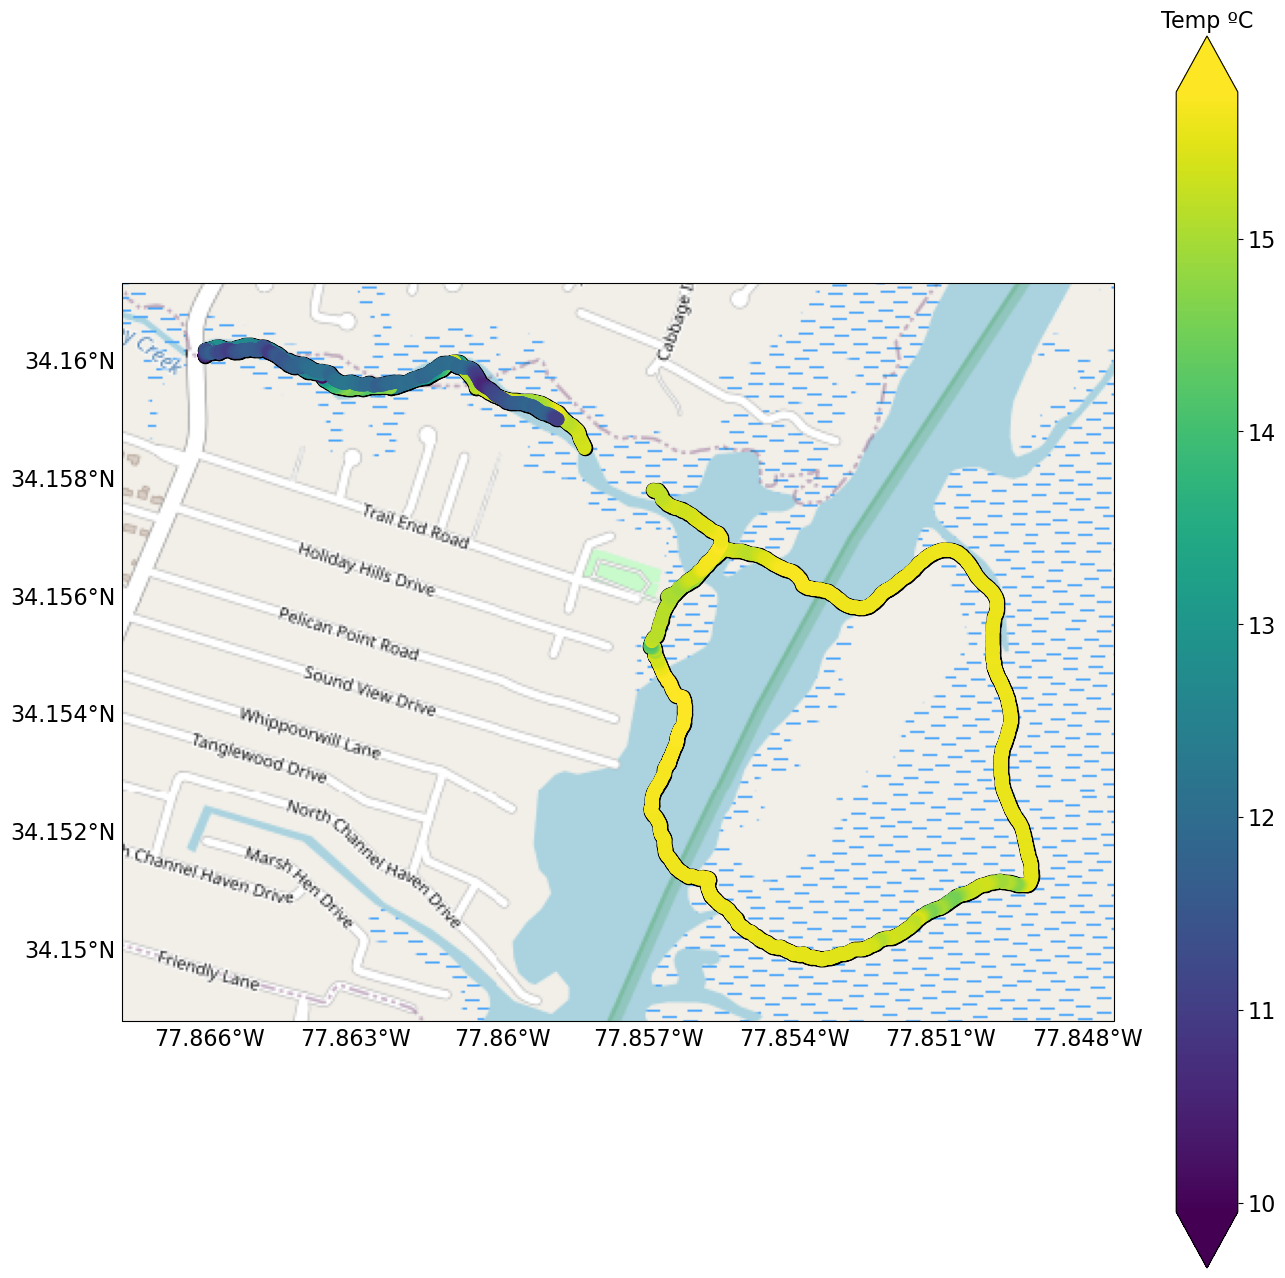

In [34]:
fig = plt.figure(figsize = (16, 16))

# Create a GeoAxes in the tile's projection.
ax = fig.add_subplot(1, 1, 1, projection=base_layer.crs)

# Limit the extent of the map to a small longitude/latitude range.
ax.set_extent([lllon_plot, urlon_plot, lllat_plot, urlat_plot], crs=crs)

# Add the Stamen data at certain zoom level.
ax.add_image(base_layer, tile_zoom)

# Plot data
sc = plt.scatter(lon, lat, c = 'black', s = 100, transform = crs)
sc = plt.scatter(lon, lat, c = plot_var, s = 75, transform = crs, vmin = plot_var_min, vmax = plot_var_max)
cb = plt.colorbar(sc, extend = 'both')
cb.ax.tick_params(labelsize = fontsize) 
cb.ax.set_title(var_name, fontsize = fontsize)

# Format gridlines
gl = ax.gridlines(crs=crs, draw_labels=True,
                  linewidth=2, color='white', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fontsize}#, 'color': 'gray'}
gl.ylabel_style = {'size': fontsize}#, 'color': 'gray'}

# plt.savefig(var_name+'.png', dpi = 300) # (un)comment depending on preference for saving figure locally